In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor






In [2]:
# read data
data = pd.read_csv('../data/filled_bridge_statistic_germany.csv', sep=';')
# remove rows with 'Traglastindex' == 0
data = data[data['Traglastindex'] != 0]
data = data.dropna()
type_encoded = pd.get_dummies(data['Teilbauwerksart'])
stadium_encoded = pd.get_dummies(data['Teilbauwerksstadium'])
superstructure_encoded = pd.get_dummies(data['Baustoff Überbau'])
federal_state_encoded = pd.get_dummies(data['Bundeslandname'])
region_encoded = pd.get_dummies(data['Kreis'])
steet_type_encoded = pd.get_dummies(data['Zugeordneter Sachverhalt vereinfacht'])






In [3]:

# get x, exclude non numeric columns
x = data.select_dtypes(include=['number'])
x = pd.concat([x, type_encoded, stadium_encoded, superstructure_encoded, federal_state_encoded, region_encoded, steet_type_encoded], axis=1)
x = x.drop(columns=['Unnamed: 0'])
x = x.drop(columns=["Zustandsnote"])


# get targets y 
y = data["Zustandsnote"]

Mean Squared Error: 0.1399987253819308
R^2 score: 0.32616164165854367


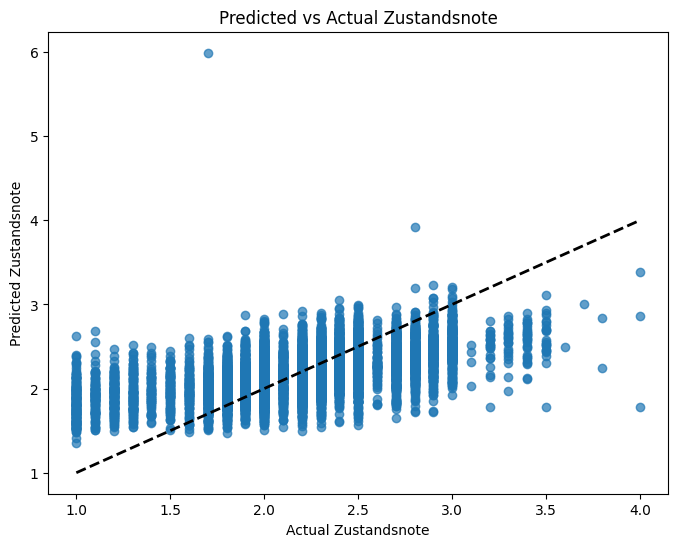

In [4]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# train linear regression model

model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)
score = model.score(X_test_scaled, y_test)
error = np.mean((y_pred - y_test) ** 2)
print("Mean Squared Error:", error)
print("R^2 score:", score)

# plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual Zustandsnote")
plt.ylabel("Predicted Zustandsnote")
plt.title("Predicted vs Actual Zustandsnote")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()


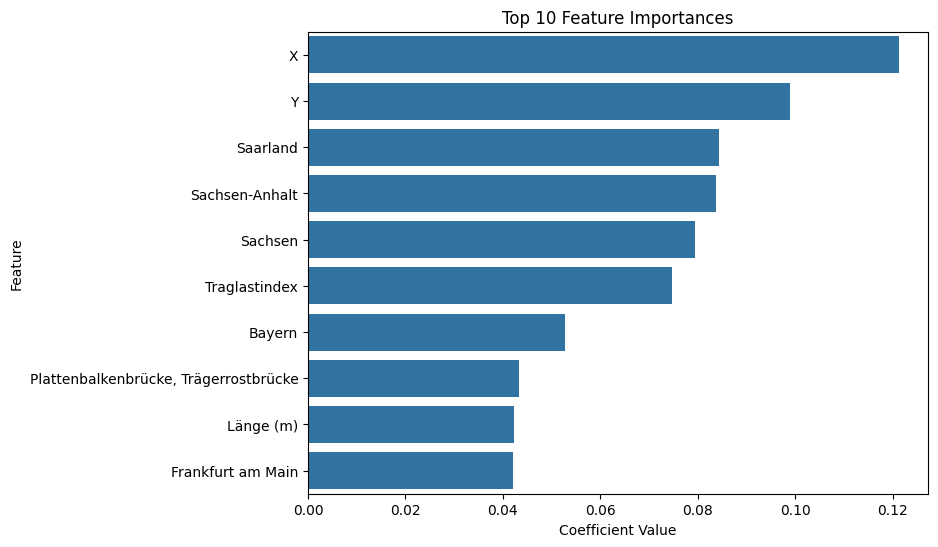

In [6]:
# plot feature importance of linear regression model (10 most important features)


importance = model.coef_
feature_names = X_train.columns
feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10])
plt.title("Top 10 Feature Importances")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

Random Forest R^2: 0.4555812063199486


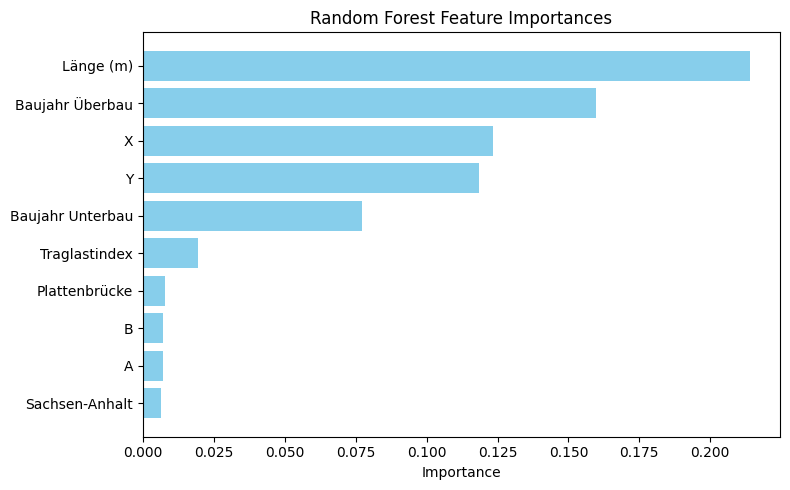

In [7]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]
print("Random Forest R^2:", rf.score(X_test, y_test))
    
# Plot feature importances
indices = np.argsort(importances)[-10:] # 10 most important features

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in indices], importances[indices], color='skyblue')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()







c:\Users\pauli\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Categorial Mean Squared Error: 0.6410031288038185
Categorial R^2 score: 0.2587482705350961


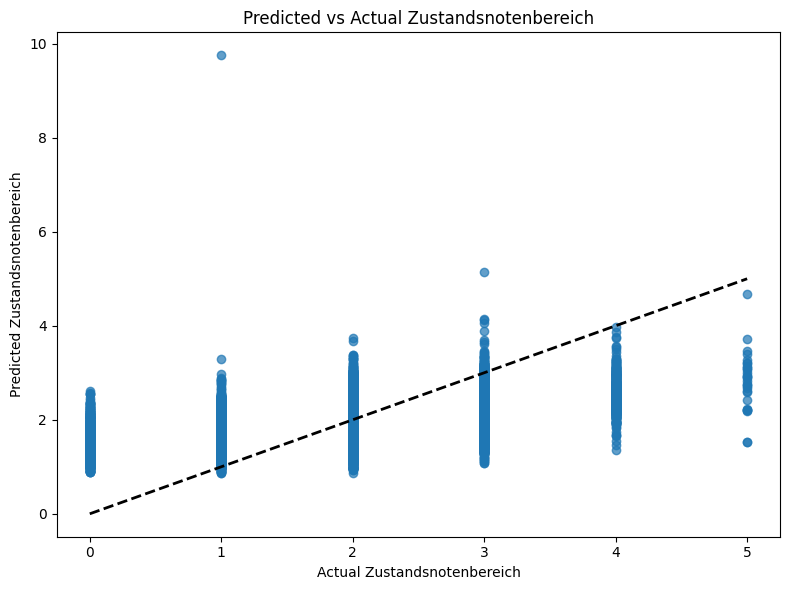

In [8]:

bins = [1.0, 1.4, 1.9, 2.4, 2.9, 3.4, 4.0]


data['Zustandsnotenbereich'] = pd.cut(
    data['Zustandsnote'],
    bins=bins,
    right=True,       # 1.4 belongs to "very good condition", etc.
    include_lowest=True
)

x_categorial = data.select_dtypes(include=['number'])
x_categorial = pd.concat([x_categorial, type_encoded, stadium_encoded, superstructure_encoded, federal_state_encoded, steet_type_encoded], axis=1)
x_categorial = x_categorial.drop(columns=['Unnamed: 0'])
x_categorial = x_categorial.drop(columns=["Zustandsnote"])
y_categorial = data["Zustandsnotenbereich"].cat.codes  # Convert categories to integer codes



X_train, X_test, y_train, y_test = train_test_split(x_categorial, y_categorial, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression( solver='saga', max_iter=4000,class_weight='balanced')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


#train regression model (not random forrest)
model_categorial = LinearRegression()
model_categorial.fit(X_train_scaled, y_train)
y_pred_categorial = model_categorial.predict(X_test_scaled)
score_categorial = model_categorial.score(X_test_scaled, y_test)
print("Categorial Mean Squared Error:", np.mean((y_pred_categorial - y_test) ** 2))
print("Categorial R^2 score:", score_categorial)

# plot predicted vs actual values for categorial
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_categorial, alpha=0.7)
plt.xlabel("Actual Zustandsnotenbereich")
plt.ylabel("Predicted Zustandsnotenbereich")
plt.title("Predicted vs Actual Zustandsnotenbereich")
plt.plot([y_categorial.min(), y_categorial.max()], [y_categorial.min(), y_categorial.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()





In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.65      0.32       649
           1       0.25      0.27      0.26      1536
           2       0.60      0.24      0.34      4594
           3       0.36      0.30      0.32      2203
           4       0.13      0.48      0.21       378
           5       0.03      0.58      0.05        31

    accuracy                           0.30      9391
   macro avg       0.26      0.42      0.25      9391
weighted avg       0.44      0.30      0.32      9391



In [12]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Classifier R^2:", rf_model.score(X_test, y_test))


Random Forest Classifier R^2: 0.5605366840592056


In [ ]:
importances = rf_model.feature_importances_
top_n = 10
top_indices = importances.argsort()[-top_n:]
for i in reversed(top_indices):
    print(f"{X_train.columns[i]}: {importances[i]:.3f}")


Länge (m): 0.158
X: 0.150
Y: 0.148
Baujahr Überbau: 0.125
Baujahr Unterbau: 0.125
Traglastindex: 0.051
B: 0.012
A: 0.012
Plattenbrücke: 0.012
Spannbeton: 0.012


In [ ]:
print(classification_report(y_test, rf_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.48      0.35      0.40       649
           1       0.44      0.35      0.39      1536
           2       0.61      0.74      0.67      4594
           3       0.52      0.46      0.49      2203
           4       0.47      0.27      0.34       378
           5       0.24      0.13      0.17        31

    accuracy                           0.56      9391
   macro avg       0.46      0.38      0.41      9391
weighted avg       0.55      0.56      0.55      9391

[[ 227  163  242   17    0    0]
 [ 146  535  757   98    0    0]
 [  94  441 3388  639   32    0]
 [  10   78 1025 1009   77    4]
 [   0    3  106  159  101    9]
 [   0    0    7   17    3    4]]
